In [70]:
import numpy as np
import pandas as pd
import time
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials
from pandas_datareader import data
import edgar
import requests
from tqdm import tqdm
import pandas as pd
from bs4 import BeautifulSoup
import statsmodels.api as sm
from operator import itemgetter 
from scipy import stats
import urllib
import zipfile
from heapq import nsmallest 
from sec_edgar_downloader import Downloader

In [64]:
# gets tickers for sp 500
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
df.to_csv('S&P500-Info.csv')
df.to_csv("S&P500-Symbols.csv", columns=['Symbol'])


'MMM'

In [ ]:
def convert_time(epoch):
    return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoch))
    
epoch_time = int(time.time())
day_epoch = 60*60*24
tickers = df['Symbol']
days_back = 400
stocks = {}
for tick in tqdm(tickers):
    try:
        stock_data = data.DataReader(tick, 
                    start=convert_time(epoch_time - (days_back* day_epoch)), 
                    end=convert_time(epoch_time), 
                    data_source='yahoo')
        stocks[tick] = stock_data 
    except:
        print("Skipping stock for {}, bad data :<".format(tick))
    


In [78]:
def addMACD(stocks):
    for stock in list(stocks): 
        exp1 = stocks[stock]['Adj Close'].ewm(span=12, adjust=False).mean()
        exp2 = stocks[stock]['Adj Close'].ewm(span=26, adjust=False).mean()
        stocks[stock]['macd'] = exp1-exp2
        stocks[stock]['macd_signal'] = stocks[stock]['macd'].ewm(span=9, adjust=False).mean()
    return(stocks)

def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

def addRSI(stocks, time_window):
    for stock in list(stocks):
        stocks[stock]["RSI"] = computeRSI(stocks[stock]["Adj Close"], time_window)
    return(stocks)

def addBB(stocks, time_window):
    for stock in list(stocks):      
        stocks[stock]['MA20'] = stocks[stock]['Adj Close'].rolling(window=time_window).mean()
        stocks[stock]['20dSTD'] = stocks[stock]['Adj Close'].rolling(window=time_window).std() 
        stocks[stock]['Upper'] = stocks[stock]['MA20'] + (stocks[stock]['20dSTD'] * 2)
        stocks[stock]['Lower'] = stocks[stock]['MA20'] - (stocks[stock]['20dSTD'] * 2)
    return(stocks)

def addReturns(stocks):
    for stock in list(stocks):
        stocks[stock]['returns'] = stocks[stock]['Adj Close'].pct_change()
    return(stocks)


stocks = addBB(stocks,20)        
stocks= addMACD(stocks)
stocks = addRSI(stocks,14)
stocks = addReturns(stocks)

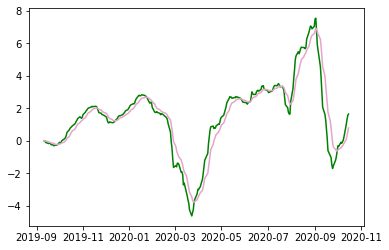

In [80]:
df=stocks["AAPL"]
plt.plot( df['macd'], label='AMD MACD', color = 'green')
plt.plot(df['macd_signal'], label='Signal Line', color='#E5A4CB')
plt.show()

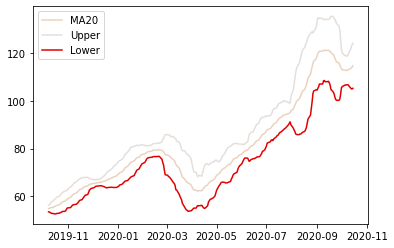

In [81]:
import matplotlib.pyplot as plt
plt.plot( df['MA20'], label='MA20', color = '#EBD2BE')
plt.plot(df['Upper'], label='Upper', color='#E5DFDB')
plt.plot(df['Lower'], label='Lower', color='#E00000')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# def add10QSentiment(stocks, current_date, start_date):
#     for stock in tickers: 
#         print(stock)
#         dl.get("10-Q", stock, after_date=start_date.strftime("%Y%M%d"), before_date=current_date.strftime("%Y%M%d"))
# add10QSentiment(stocks,current_date,start_date)

In [6]:
# import os
# dir = "./edgars/sec_edgar_filings/AAPL/10-Q/"
# directory = os.fsencode("./edgars/sec_edgar_filings/AAPL/10-Q/")
# for file in os.listdir(directory):
#     filename = os.fsdecode(file)
#     if(filename.endswith(".txt") or filename.endswith(".py")):
#         #print(filename)
#         #year = filename[]
#         path = os.path.join(dir, filename)
#         #print(path)
#         text = open(path,'r').read()
#         #print(text[:100])

In [82]:
features = ['High', 'Low', 'Open', 'Close', 'Volume', 'MA20', '20dSTD', 'Upper', 'Lower', 'macd', 'macd_signal', 'RSI']

In [84]:
def lagFeatures(stocks_lagged, features, periods):
    for stock in list(stocks):
        stocks_lagged[stock][features] = stocks_lagged[stock][features].shift(periods)
    return(stocks)
stocks_lagged = lagFeatures(stocks,features,1)

In [85]:
def dict_2_panel(stocks_lagged):  
    df = pd.DataFrame()
    for stock in list(stocks):
        df = df.append(stocks_lagged[stock])
    return df
df = dict_2_panel(stocks_lagged)

In [86]:
df = df.dropna()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014D3527F6D0>,
      dtype=object)

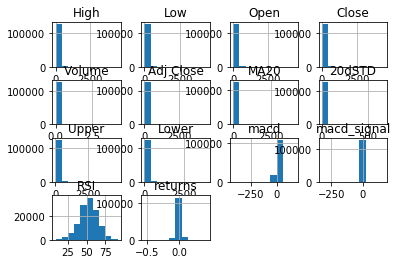

In [87]:
df.hist()

In [89]:
# this cell might need to be run twice
X = pd.DataFrame(df[features])
y = pd.DataFrame(df['returns'])
X2 = sm.add_constant(X)
est = sm.OLS(y,X2)
est2 = est.fit()
# print(est2.summary())
p_values = est2.summary2().tables[1]['P>|t|']
coef = est2.summary2().tables[1]['Coef.']

In [90]:
p_dict = {}
coef_dict = {}
for i in range(0,len(features), 1):
    p_dict[features[i]] = p_values[i]
    coef_dict[features[i]] = coef[i]

In [91]:
sig_level = 0.05
p_sig = {k:v for k,v in p_dict.items() if v < sig_level}

In [92]:
# order to sort
p_sort = nsmallest(len(p_dict), p_sig, key = p_dict.get) 

In [139]:
p_sort

['Volume',
 'Open',
 'Close',
 'Low',
 'Lower',
 '20dSTD',
 'RSI',
 'macd_signal',
 'macd',
 'High']

In [95]:
# get most recent value for each stock
def getLastValue(stock_df, factor):
    return(stock_df.tail(n=1)[factor].values[0])

factor = "RSI"
result = {}
for stock in list(stocks):
    result[stock] = getLastValue(stocks[stock], factor)

test = getLastValue(stocks['AAPL'], 'RSI')

In [98]:
def getStockValues(features):
    sorted_stocks = {}
    for factor in features:
        result = {}
        for stock in list(stocks):
            result[stock] = getLastValue(stocks[stock], factor)
        sorted_stocks[factor] = result  
    return sorted_stocks
sorted_stocks = getStockValues(features)

In [126]:
top_p = 0.4
sort_n = 4
remove_list = ['Open', 'Close', 'Volume', 'High', 'Low']

def buyDecision(sorted_stocks, top_p, sort_n, p_sort, remove_list, tickers):
    final = tickers
    p_sort = [i for i in p_sort if i not in remove_list]
    print("Initial length to sort:")
    print(len(final))
    for factor in p_sort[:sort_n]:
        print("For factor {}".format(factor))
        # based on wheter coefficient is pos or neg, then get largest value, or smallest value respectively
#         dict_filter = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
#         new_dict_keys = (final)
#         buy_order=dict_filter(buy_order, new_dict_keys)
        res = dict(sorted(sorted_stocks[factor].items(), key = itemgetter(1), reverse = (coef_dict[factor] > 0))[:round(len(final)*top_p)]) 
        keep = list(res.keys())
        final = keep
        print("Reduced to length: {}".format(len(final)))
        print("New list: {}".format(final))
        if (len(final) < 5):
            break
    return(final)
    
stocks_to_buy = buyDecision(sorted_stocks, top_p, sort_n, p_sort, remove_list, tickers)

Initial length to sort:
505
For factor Volume
Reduced to length: 202
New list: ['NVR', 'MTD', 'TDY', 'BIO', 'IPGP', 'TYL', 'MKTX', 'AZO', 'TFX', 'COO', 'ABMD', 'HII', 'GWW', 'AIZ', 'SNA', 'SIVB', 'CMG', 'PAYC', 'BR', 'IDXX', 'BKNG', 'MKC', 'SBAC', 'ESS', 'MSCI', 'ZBRA', 'AVY', 'HUM', 'STE', 'JKHY', 'EFX', 'FRT', 'POOL', 'PKG', 'LH', 'EMN', 'ANSS', 'CINF', 'RMD', 'RE', 'IEX', 'UHS', 'ORLY', 'TDG', 'WRB', 'CTAS', 'SHW', 'FMC', 'MLM', 'MSI', 'GRMN', 'ODFL', 'WLTW', 'PRGO', 'SJM', 'GL', 'ROK', 'VRSN', 'ANET', 'EQIX', 'PH', 'LEG', 'MCO', 'NWS', 'MAA', 'LW', 'WAT', 'CE', 'KSU', 'WHR', 'ULTA', 'ALGN', 'FLT', 'DVA', 'ROL', 'ROP', 'DXCM', 'ITW', 'IT', 'MHK', 'NDAQ', 'DOV', 'WST', 'VRSK', 'HSY', 'FBHS', 'AWK', 'LDOS', 'SNPS', 'HAS', 'AIV', 'XRAY', 'RHI', 'AME', 'ISRG', 'DGX', 'J', 'SWK', 'SEE', 'PSA', 'RJF', 'ECL', 'RSG', 'FFIV', 'ATO', 'JBHT', 'CDW', 'FRC', 'MTB', 'NTRS', 'BLK', 'STZ', 'ALLE', 'ABC', 'TIF', 'WAB', 'GPC', 'EXPD', 'REG', 'LHX', 'PVH', 'HSIC', 'SYK', 'AMP', 'AAP', 'L', 'IQV', 'XYL

<ipython-input-126-0e0575cbe29a>:16: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  res = dict(sorted(sorted_stocks[factor].items(), key = itemgetter(1), reverse = (coef_dict[factor] > 0))[:round(len(final)*top_p)])


In [140]:
stock_weight = 1/len(stocks_to_buy)
weights = [stock_weight if x in stocks_to_buy else 0 for x in tickers]

In [128]:
price_data  = data.DataReader(tickers, 
                    start=convert_time(epoch_time - (days_back * day_epoch)), 
                    end=convert_time(epoch_time), 
                    data_source='yahoo')

price_data = price_data['Adj Close']

ret_data = price_data.pct_change()[1:]
print(ret_data.head())
weighted_returns = (weights * ret_data)
print(weighted_returns.head())

port_ret = weighted_returns.sum(axis=1)

C:\Users\moyer\anaconda3\envs\birdi\lib\site-packages\pandas_datareader\base.py:272: SymbolWarning: Failed to read symbol: 'BRK.B', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
C:\Users\moyer\anaconda3\envs\birdi\lib\site-packages\pandas_datareader\base.py:272: SymbolWarning: Failed to read symbol: 'BF.B', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


Symbols          MMM       ABT      ABBV      ABMD       ACN      ATVI  \
Date                                                                     
2019-09-12  0.014874  0.008164  0.019283 -0.015963  0.021686  0.009834   
2019-09-13  0.005042 -0.011031 -0.004518 -0.008563 -0.004603  0.009017   
2019-09-16 -0.010324 -0.010799  0.000993  0.022155 -0.002364 -0.003038   
2019-09-17 -0.009430  0.002639  0.014452  0.000000  0.004069 -0.007709   
2019-09-18 -0.003749  0.000718 -0.004609  0.000682 -0.004206 -0.004155   

Symbols         ADBE       AMD       AAP       AES  ...       XRX      XLNX  \
Date                                                ...                       
2019-09-12  0.000864  0.015121 -0.023039  0.007717  ... -0.024336 -0.000190   
2019-09-13  0.001187  0.015889  0.011598  0.007658  ...  0.011487  0.001999   
2019-09-16  0.016454  0.004562 -0.005923  0.013300  ...  0.007787 -0.008077   
2019-09-17  0.006221  0.005190  0.000000 -0.006875  ... -0.010625 -0.001054   
2019-09

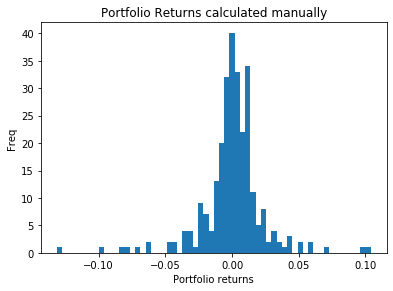

In [141]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.hist(port_ret, bins = 60)
ax1.set_xlabel('Portfolio returns')
ax1.set_ylabel("Freq")
ax1.set_title("Portfolio Returns calculated manually")
plt.show(); 

In [142]:
mean_ret = port_ret.mean()
std_returns = port_ret.std()
print(mean_ret)
print(std_returns)

0.0006455153540793194
0.023409904288755355


In [133]:
port_mon = port_ret.resample('M').agg(lambda x: (x + 1).prod() - 1)

In [134]:
def get_fama_french():
    # Web url
    ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
    
    # Download the file and save it
    # We will name it fama_french.zip file
    
    urllib.request.urlretrieve(ff_url,'fama_french.zip')
    zip_file = zipfile.ZipFile('fama_french.zip', 'r')
    
    # Next we extact the file data
    
    zip_file.extractall()
    
    # Make sure you close the file after extraction
    
    zip_file.close()
    
    # Now open the CSV file
    
    ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, index_col = 0)
    # We want to find out the row with NULL value
    # We will skip these rows
    
    #ff_row = ff_factors.isnull().any(1).nonzero()[0][0]
    
    # Read the csv file again with skipped rows
    ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, nrows = 1130, index_col = 0)
    
    # Format the date index
    ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m')
    
    # Format dates to end of month
    ff_factors.index = ff_factors.index + pd.offsets.MonthEnd()
    
    # Convert from percent to decimal
    ff_factors = ff_factors.apply(lambda x: x/ 100)
    return ff_factors

ff_data = get_fama_french()
ff_features = [ff_data.columns][0]
print(ff_data.tail())

            Mkt-RF     SMB     HML      RF
2020-04-30  0.1365  0.0275 -0.0135  0.0000
2020-05-31  0.0558  0.0247 -0.0495  0.0001
2020-06-30  0.0246  0.0270 -0.0222  0.0001
2020-07-31  0.0577 -0.0222 -0.0132  0.0001
2020-08-31  0.0762 -0.0010 -0.0310  0.0001


In [138]:
ff_data['port'] = port_mon
df = ff_data.dropna()
X = pd.DataFrame(df[ff_features])
y = pd.DataFrame(df['port'])
X2 = sm.add_constant(X)
est = sm.OLS(y,X2)
est2 = est.fit()
print(est2.summary())
#p_values = est2.summary2().tables[1]['P>|t|']
#coef = est2.summary2().tables[1]['Coef.']

# model = LinearRegression()
# scores = []
# kfold = KFold(n_splits=3, shuffle=True, random_state=42)
# reg = model.fit(X, y)

                            OLS Regression Results                            
Dep. Variable:                   port   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     30.22
Date:                Thu, 15 Oct 2020   Prob (F-statistic):           0.000165
Time:                        09:37:03   Log-Likelihood:                 29.042
No. Observations:                  12   AIC:                            -48.08
Df Residuals:                       7   BIC:                            -45.66
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0077      0.028      0.277      0.7

C:\Users\moyer\anaconda3\envs\birdi\lib\site-packages\scipy\stats\stats.py:1534: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
